In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot
import matplotlib.animation as animation
import math
import itertools as itool

In [2]:
class BoundaryCondition:
    RBC, PBC = range(2)
    
class StartConf:
    Triangular, Rectangular, Random, Confined = range(4)

In [3]:
class particle2(object):

    def __init__(self, mass=1., x=0., y=0., vx=0., vy=0.):
        self.mass = mass
        self.x = x
        self.y = y
        self.vx = vx
        self.vy = vy
        self.fx = 0.
        self.fy = 0.
       
    def euler(self, fx, fy, dt):
        self.vx = self.vx + self.fx/self.mass*dt
        self.vy = self.vy + self.fy/self.mass*dt
        self.x = self.x + self.vx*dt
        self.y = self.y + self.vy*dt
        
    def accel(self, dt):
        self.vx = self.vx + self.fx/self.mass*dt
        self.vy = self.vy + self.fy/self.mass*dt
        
    def move(self, dt, dt2half):
        self.x = self.x + self.vx*dt + self.fx/self.mass*dt2half
        self.y = self.y + self.vy*dt + self.fy/self.mass*dt2half      

In [4]:
class MDsystem(object):

    def __init__(self, lx, ly, N, dt, bc): 
        self.N = N
        self.lx = ly
        self.ly = lx
        self.dt = dt
        self.dt2 = dt*dt
        self.dthalf = dt * 0.5
        self.dt2half = self.dt2 * 0.5
        self.bc = bc
        self.particles = [particle2()]
        for i in range(1,N):
            self.particles.append(particle2())

    def init(self, config, vmax):
        np.random.seed(1272121) # arbitrary seed
        nrows = int(math.sqrt(N*float(self.ly)/float(self.lx)));
        ncols = int(math.sqrt(N*float(self.lx)/float(self.ly)));
        ax = float(lx) / float(ncols);
        ay = float(ly) / float(nrows);
        i = 0;

        if config == StartConf.Triangular:
            #Challenge
            return
        elif config == StartConf.Rectangular:
            for row, col in itool.product(range(ncols),range(ncols)):
                if i >= self.N: 
                    break
                self.particles[i].x = col*ax+ax/2
                self.particles[i].y = row*ay+ay/2
                i+=1

            for row, col in itool.product(range(1,ncols),range(1,ncols)):
                if i >= self.N: 
                    break
                self.particles[i].x = col*ax/2.+ax/2.
                self.particles[i].y = row*ay/2.+ay/2.
                i+=1
                
        elif config == StartConf.Confined:
            for row, col in itool.product(range(ncols),range(ncols)):
                if i >= self.N: 
                    break
                self.particles[i].x = (col*ax+ax/2.)/2.
                self.particles[i].y = (row*ay+ay/2.)
                i+=1

            for row, col in itool.product(range(1,ncols),range(1,ncols)):
                if i >= self.N: 
                    break
                self.particles[i].x = (col*ax/2.+ax/2.)/2.
                self.particles[i].y = (row*ay/2.+ay/2.)
                i+=1
                
        elif config == StartConf.Random:
            for i in range(self.N):
                overlap = True;
                while overlap:
                    overlap = False;
                    self.particles[i].x = np.random.random()*self.lx
                    self.particles[i].y = np.random.random()*self.ly
                    for j in range(i):
                        r12 = self.distance(self.particles[i], self.particles[j])
                        if r12 < 1.: 
                            overlap = True;
                            break
                                
        # Velocities
        for p in self.particles:
            p.vx = vmax*(2. * np.random.random() - 1);
            p.vy = vmax*(2. * np.random.random() - 1);

        # We set total momentum to zero
        vxcm = 0.
        vycm = 0. # Velocity of the center of mass
        for p in self.particles:
            vxcm += p.vx;
            vycm += p.vy;
        
        vxcm /= self.N
        vycm /= self.N
        for p in self.particles:
            p.vx -= vxcm;
            p.vy -= vycm;
            
        self.forces()          
        
    def evolve(self):
        for p in self.particles:
            p.move(self.dt, self.dt2half)
            p.accel(self.dthalf)
            self.boundary(p)

        self.forces()

        for p in self.particles:
            p.accel(self.dthalf)

        
    def distance(self, p, other):
        (r12, dx, dy) = self.distance2(p, other)
        return math.sqrt(r12)

    def distance2(self, p, other):
        dx = other.x - p.x;
        dy = other.y - p.y;
        # nearest image convention
        if self.bc == BoundaryCondition.PBC:
            if abs(dx) > self.lx/2:
                dx -= dx*lx/abs(dx)
                
            if abs(dy) > self.ly/2:
                dy -= dy*ly/abs(dy)
        
        r12 = dx * dx + dy * dy
        return (r12, dx, dy)

    def force(self, p, other):  #Lennard-Jones
        (r12,dx,dy) = self.distance2(p, other)
        r2 = 1./r12
        r6 = r2 * r2 * r2
        f = 24.*r2*r6*(2.*r6-1.)
        fx = f*(-dx)
        fy = f*(-dy)
        return (fx, fy);
      
    def forces(self):
        # Compute the interaction forces between particles
        for p in self.particles:
            p.fx = 0.
            p.fy = 0.
    
        for i in range(self.N):
            p = self.particles[i]
            for j in range(i+1,self.N):
                other = self.particles[j]
                (fx, fy) = self.force(p, other)
                p.fx += fx
                p.fy += fy
                other.fx -= fx
                other.fy -= fy

    def boundary(self, p):
        if self.bc == BoundaryCondition.RBC:
            
            if p.x < 0:  
                p.x = -p.x
                p.vx = -p.vx
            if p.y < 0:
                p.y = -p.y
                p.vy = -p.vy
            if p.x > self.lx:
                p.x = 2*self.lx - p.x
                p.vx = -p.vx
            if p.y > self.ly:
                p.y = 2*self.ly - p.y
                p.vy = -p.vy

        elif self.bc == BoundaryCondition.PBC:

            if p.x < 0: 
                p.x += lx
            elif p.x > lx:  
                p.x -= lx
            if p.y < 0:  
                p.y += ly
            elif p.y > ly:  
                p.y -= ly

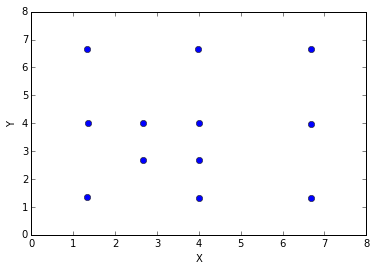

In [8]:
lx = 8
ly = 8
N = 12
dt = 0.02
v0 = 1.
t =30
tsteps = int(t/dt)

S = MDsystem(lx, ly, N, dt, BoundaryCondition.RBC)
S.init(StartConf.Rectangular, v0)

x = np.zeros(N)
y = np.zeros(N)


fig = pyplot.figure()
ax = pyplot.axes(xlim=(0, lx), ylim=(0, ly), xlabel='X', ylabel='Y')
points, = ax.plot([], [], marker='o', linestyle='None')

def animate(i):
    S.evolve()
    for n in range(S.N):
        p = S.particles[n]
        x[n] = p.x
        y[n] = p.y
    points.set_data(x, y)
    return points


anim = animation.FuncAnimation(fig, animate, frames = 1000, interval=100, blit=True)

Initial configuration.

1.06508040919


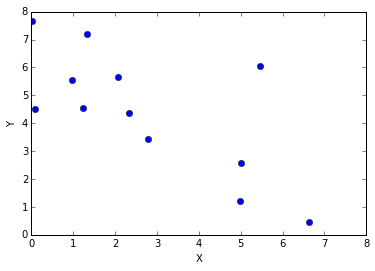

In [11]:
x = np.zeros(N)
y = np.zeros(N)
vx = np.zeros(N)
vy = np.zeros(N)
vsquare = np.zeros(N)

for i in range(tsteps):
    S.evolve()
    for n in range(S.N):
        p = S.particles[n]    
        x[n] = p.x
        y[n] = p.y
        vx[n] = p.vx
        vy[n] = p.vy
        vsquare[n] = vx[n]**2+vy[n]**2
        
fig = pyplot.figure()
ax = pyplot.axes(xlim=(0, lx), ylim=(0, ly), xlabel='X', ylabel='Y')
ax.plot(x, y, marker='o', linestyle='None')


The above plot is the configuration at $t = 30s$ after $1500$ steps. 

In [12]:
avg_vsquare = sum(vsquare)/float(len(vsquare))
print avg_vsquare

1.06508040919


The above calculation shows the average velocity squared of the particles is about $1.065(m/s)^{2}$. If we want to set the desired temperature to room temperature $~298K$, then we need to scale up the velocities to the corresponding value $~165.85m/s$, where the mass of a water molecule $2.99*10^{-25}kg$ was used for the calculation. Therefore the velocity must be scaled by a factor of $~160$. 

In [29]:
x = np.zeros(N)
y = np.zeros(N)
vx = np.zeros(N)
vy = np.zeros(N)
vsquare = np.zeros(N)

for i in range(tsteps):
    S.evolve()
    for n in range(S.N):
        p = S.particles[n]    
        x[n] = p.x
        y[n] = p.y
        vx[n] = p.vx
        vy[n] = p.vy
        vsquare[n] = vx[n]**2+vy[n]**2
        
avg_vsquare = sum(vsquare)/float(len(vsquare))
print avg_vsquare

1.26706741771


Here we repeat what we have done in the previous step and scale the velocity by a factor of $~159$.

In [14]:
x = np.zeros(N)
y = np.zeros(N)
vx = np.zeros(N)
vy = np.zeros(N)
vsquare = np.zeros(N)

for i in range(tsteps):
    S.evolve()
    for n in range(S.N):
        p = S.particles[n]    
        x[n] = p.x
        y[n] = p.y
        vx[n] = p.vx
        vy[n] = p.vy
        vsquare[n] = vx[n]**2+vy[n]**2
        
avg_vsquare = sum(vsquare)/float(len(vsquare))
print avg_vsquare

1.15628259699


In [15]:
x = np.zeros(N)
y = np.zeros(N)
vx = np.zeros(N)
vy = np.zeros(N)
vsquare = np.zeros(N)

for i in range(tsteps):
    S.evolve()
    for n in range(S.N):
        p = S.particles[n]    
        x[n] = p.x
        y[n] = p.y
        vx[n] = p.vx
        vy[n] = p.vy
        vsquare[n] = vx[n]**2+vy[n]**2
        
avg_vsquare = sum(vsquare)/float(len(vsquare))
print avg_vsquare

1.25058587037


In [16]:
x = np.zeros(N)
y = np.zeros(N)
vx = np.zeros(N)
vy = np.zeros(N)
vsquare = np.zeros(N)

for i in range(tsteps):
    S.evolve()
    for n in range(S.N):
        p = S.particles[n]    
        x[n] = p.x
        y[n] = p.y
        vx[n] = p.vx
        vy[n] = p.vy
        vsquare[n] = vx[n]**2+vy[n]**2
        
avg_vsquare = sum(vsquare)/float(len(vsquare))
print avg_vsquare

1.07257184934


In [24]:
x = np.zeros(N)
y = np.zeros(N)
vx = np.zeros(N)
vy = np.zeros(N)
vsquare = np.zeros(N)

for i in range(tsteps):
    S.evolve()
    for n in range(S.N):
        p = S.particles[n]    
        x[n] = p.x
        y[n] = p.y
        vx[n] = p.vx
        vy[n] = p.vy
        vsquare[n] = vx[n]**2+vy[n]**2
        
avg_vsquare = sum(vsquare)/float(len(vsquare))
print avg_vsquare

1.01145924767


In [23]:
x = np.zeros(N)
y = np.zeros(N)
vx = np.zeros(N)
vy = np.zeros(N)
vsquare = np.zeros(N)

for i in range(tsteps):
    S.evolve()
    for n in range(S.N):
        p = S.particles[n]    
        x[n] = p.x
        y[n] = p.y
        vx[n] = p.vx
        vy[n] = p.vy
        vsquare[n] = vx[n]**2+vy[n]**2
        
avg_vsquare = sum(vsquare)/float(len(vsquare))
print avg_vsquare

1.15028085943


In [22]:
x = np.zeros(N)
y = np.zeros(N)
vx = np.zeros(N)
vy = np.zeros(N)
vsquare = np.zeros(N)

for i in range(tsteps):
    S.evolve()
    for n in range(S.N):
        p = S.particles[n]    
        x[n] = p.x
        y[n] = p.y
        vx[n] = p.vx
        vy[n] = p.vy
        vsquare[n] = vx[n]**2+vy[n]**2
        
avg_vsquare = sum(vsquare)/float(len(vsquare))
print avg_vsquare

1.15163581442


In [25]:
x = np.zeros(N)
y = np.zeros(N)
vx = np.zeros(N)
vy = np.zeros(N)
vsquare = np.zeros(N)

for i in range(tsteps):
    S.evolve()
    for n in range(S.N):
        p = S.particles[n]    
        x[n] = p.x
        y[n] = p.y
        vx[n] = p.vx
        vy[n] = p.vy
        vsquare[n] = vx[n]**2+vy[n]**2
        
avg_vsquare = sum(vsquare)/float(len(vsquare))
print avg_vsquare

1.22001428022


We see that the velocity squared fluctuates and eventually settles to about $1.15(m/s)^{2}$, therefore we scale it by a factor of $155$ to match the desired temperature.

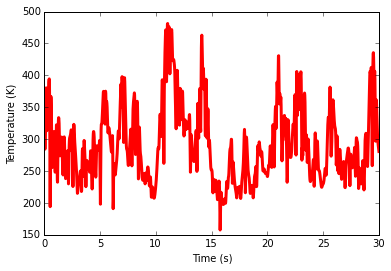

In [36]:
Temp = np.zeros(tsteps)
time = np.linspace(0., t, tsteps)

for i in range(tsteps):
    S.evolve()
    for n in range(S.N):
        p = S.particles[n]    
        x[n] = p.x
        y[n] = p.y
        vx[n] = p.vx
        vy[n] = p.vy
        vsquare[n] = vx[n]**2+vy[n]**2
    avg_vsquare = sum(vsquare)/float(len(vsquare))
    Temp[i]=(avg_vsquare*155**2*2.99*10**(-25)/2)/(1.38*10**(-23))
        
pyplot.plot(time, Temp, color='r', ls='-', lw=3)
pyplot.xlabel('Time (s)')
pyplot.ylabel('Temperature (K)');

The above plot is plotted over time interval of $0.02s$.

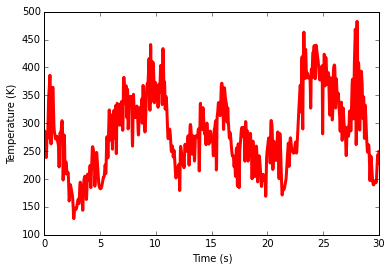

In [37]:
t = 30
dt = 0.01

Temp = np.zeros(tsteps)
time = np.linspace(0., t, tsteps)

for i in range(tsteps):
    S.evolve()
    for n in range(S.N):
        p = S.particles[n]    
        x[n] = p.x
        y[n] = p.y
        vx[n] = p.vx
        vy[n] = p.vy
        vsquare[n] = vx[n]**2+vy[n]**2
    avg_vsquare = sum(vsquare)/float(len(vsquare))
    Temp[i]=(avg_vsquare*155**2*2.99*10**(-25)/2)/(1.38*10**(-23))
        
pyplot.plot(time, Temp, color='r', ls='-', lw=3)
pyplot.xlabel('Time (s)')
pyplot.ylabel('Temperature (K)');

The above plot is plotted over time interval of $0.01s$.

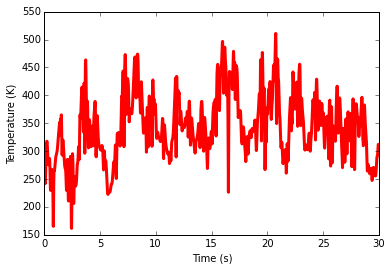

In [38]:
t = 30
dt = 0.05

Temp = np.zeros(tsteps)
time = np.linspace(0., t, tsteps)

for i in range(tsteps):
    S.evolve()
    for n in range(S.N):
        p = S.particles[n]    
        x[n] = p.x
        y[n] = p.y
        vx[n] = p.vx
        vy[n] = p.vy
        vsquare[n] = vx[n]**2+vy[n]**2
    avg_vsquare = sum(vsquare)/float(len(vsquare))
    Temp[i]=(avg_vsquare*155**2*2.99*10**(-25)/2)/(1.38*10**(-23))
        
pyplot.plot(time, Temp, color='r', ls='-', lw=3)
pyplot.xlabel('Time (s)')
pyplot.ylabel('Temperature (K)');

The above plot is plotted over time interval of $0.05s$.

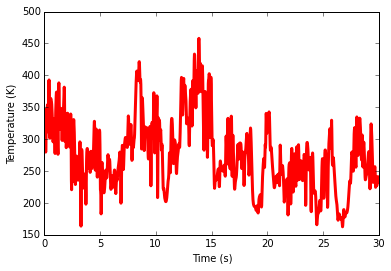

In [39]:
t = 30
dt = 0.1

Temp = np.zeros(tsteps)
time = np.linspace(0., t, tsteps)

for i in range(tsteps):
    S.evolve()
    for n in range(S.N):
        p = S.particles[n]    
        x[n] = p.x
        y[n] = p.y
        vx[n] = p.vx
        vy[n] = p.vy
        vsquare[n] = vx[n]**2+vy[n]**2
    avg_vsquare = sum(vsquare)/float(len(vsquare))
    Temp[i]=(avg_vsquare*155**2*2.99*10**(-25)/2)/(1.38*10**(-23))
        
pyplot.plot(time, Temp, color='r', ls='-', lw=3)
pyplot.xlabel('Time (s)')
pyplot.ylabel('Temperature (K)');

The above plot is plotted over time interval of $0.1s$.

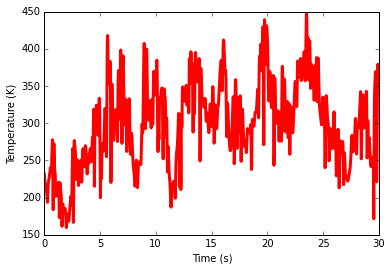

In [40]:
t = 30
dt = 0.5

Temp = np.zeros(tsteps)
time = np.linspace(0., t, tsteps)

for i in range(tsteps):
    S.evolve()
    for n in range(S.N):
        p = S.particles[n]    
        x[n] = p.x
        y[n] = p.y
        vx[n] = p.vx
        vy[n] = p.vy
        vsquare[n] = vx[n]**2+vy[n]**2
    avg_vsquare = sum(vsquare)/float(len(vsquare))
    Temp[i]=(avg_vsquare*155**2*2.99*10**(-25)/2)/(1.38*10**(-23))
        
pyplot.plot(time, Temp, color='r', ls='-', lw=3)
pyplot.xlabel('Time (s)')
pyplot.ylabel('Temperature (K)');

The above plot is plotted over time interval of $0.1s$.

We can see from the above plots that the smaller time steps we take, the more detailed flucturation in temperature is shown, and the fluctuations are around the desired temperature of $~298K$. The fluctuations get smaller as the system approaches equilibrium.

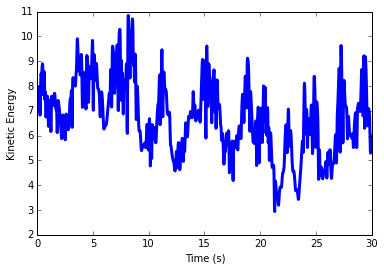

In [59]:
t= 30
dt = 0.02
tsteps = int(t/dt)

time = np.linspace(0, t, tsteps)

for i in range(tsteps):
    S.evolve()
    for n in range(S.N):
        p = S.particles[n]    
        x[n] = p.x
        y[n] = p.y
        vx[n] = p.vx
        vy[n] = p.vy
        vsquare[n] = vx[n]**2+vy[n]**2
    KE[i]=0.5*(sum(vsquare))
        
pyplot.plot(time, KE, color='blue', ls='-', lw=3)
pyplot.xlabel('Time (s)')
pyplot.ylabel('Kinetic Energy');

We see that the kinetic energy is not conserved.

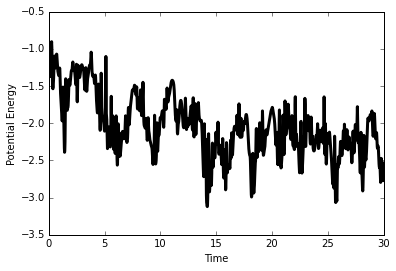

In [67]:
lx = 8
ly = 8
N = 12
dt = 0.02
t = 30
tsteps=int(t/dt)

S = MDsystem(lx, ly, N, dt, BoundaryCondition.RBC)
S.init(StartConf.Rectangular, v0)

x = np.zeros(N)
y = np.zeros(N)

PE = np.zeros(steps)
time = np.linspace(0., t, tsteps)

for i in range(steps):
    S.evolve()
    for l in range(S.N):
        p = S.particles[l]    
        x[l] = p.x
        y[l] = p.y
    add = 0
    for j in range(S.N):
        for k in range(S.N):
            if k==j:
                add = add
            else:
                add = add + 1/((x[k]-x[j])*(x[k]-x[j])+(y[k]-y[j])*(y[k]-y[j]))**6-1/((x[k]-x[j])*(x[k]-x[j])+(y[k]-y[j])*(y[k]-y[j]))**3
    PE[i]=add*0.5
        
pyplot.plot(time, PE, color='black', ls='-', lw=3)
pyplot.xlabel('Time')
pyplot.ylabel('Potential Energy');

We see that potential energy alone is not conserved either.